In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model.generation import WCGAN_GP
from dataset.DataGeneration import DamageDataGenerationDataset
from model.extraction import AE
from model.regression import CNN
from torch.utils.data import DataLoader

/home/tingyan/.conda/envs/icshm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# feature_Extractor = CNN.load_from_checkpoint("Logs/Identification/Displacement-regression/From_scratch/version_2/checkpoints/epoch=00343-val_loss=0.0000.ckpt").model.to("cuda")
feature_Extractor = AE.load_from_checkpoint("./Logs/Extraction/Displacement/LAST/version_0/checkpoints/epoch=00197-val_loss=0.00000553.ckpt").to("cuda")
# feature_Extractor = TripletAE.load_from_checkpoint("./Logs/Extraction/Displacement-TripletAE/LAST/version_0/checkpoints/epoch=00184-val_loss=0.00032279.ckpt").to("cuda")
WCGAN_mean = WCGAN_GP.load_from_checkpoint("./Logs/Generation/Displacement_mean_constraint/LAST/version_0/checkpoints/epoch=00199.ckpt").to("cuda")
WCGAN_no_mean = WCGAN_GP.load_from_checkpoint("./Logs/Generation/Displacement_no_constraint/LAST/version_0/checkpoints/epoch=00199.ckpt").to("cuda")

In [3]:
train_dataset = DamageDataGenerationDataset(path="./Data", source="Displacement")
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True) 

#### Baseline

In [4]:
real_representation_list = []
condition_list = []
with torch.no_grad():
    for real_data, condition in train_dataloader:
        real_data = real_data.to("cuda")
        real_representation_list += feature_Extractor(real_data)[-1].unsqueeze(0)
        condition_list += condition.unsqueeze(0)

    real_representation_list = torch.concat(real_representation_list).cpu().numpy()
    condition_list = torch.concat(condition_list).cpu().numpy()

In [5]:
real_representation_list.shape

(16940, 1024, 1)

In [6]:
index = int(real_representation_list.shape[0]/2)
fid = WCGAN_mean.calculate_fid(real_representation_list[:index,:,:], real_representation_list[index:,:,:])
fjd = WCGAN_mean.calculate_fjd(real_representation_list[:index,:,:], real_representation_list[index:,:,:], condition_list[:index,:], condition_list[index:,:])
print(f"Baseline FID: {fid:.4f}")
print(f"Baseline FJD: {fjd:.4f}")

Baseline FID: 0.0207
Baseline FJD: 0.0339


In [7]:
real_data_list = []
generative_data_list_mean = []
generative_data_list_no_mean = []

real_representation_list = []
generative_representation_list_mean = []
generative_representation_list_no_mean = []
condition_list = []

situation_list = []

with torch.no_grad():
    for real_data, condition in train_dataloader:
        z = torch.rand((condition.shape[0], 82)).to("cuda")
        condition = condition.to("cuda")
        real_data = real_data.to("cuda")

        synthetic_data_mean = WCGAN_mean(z, condition)
        synthetic_data_no_mean = WCGAN_no_mean(z, condition)

        real_data_list += real_data.unsqueeze(0)
        generative_data_list_mean += synthetic_data_mean.unsqueeze(0)
        generative_data_list_no_mean += synthetic_data_no_mean.unsqueeze(0)
        condition_list += condition.unsqueeze(0)

        real_representation_list += feature_Extractor(real_data)[-1].unsqueeze(0)
        generative_representation_list_mean += feature_Extractor(synthetic_data_mean)[-1].unsqueeze(0)
        generative_representation_list_no_mean += feature_Extractor(synthetic_data_no_mean)[-1].unsqueeze(0)




real_data_list = torch.concat(real_data_list).cpu().numpy()
generative_data_list_mean = torch.concat(generative_data_list_mean).cpu().numpy()
generative_data_list_no_mean = torch.concat(generative_data_list_no_mean).cpu().numpy()

real_representation_list = torch.concat(real_representation_list).cpu().numpy()
generative_representation_list_mean = torch.concat(generative_representation_list_mean).cpu().numpy()
generative_representation_list_no_mean = torch.concat(generative_representation_list_no_mean).cpu().numpy()

condition_list = torch.concat(condition_list).cpu().numpy()

In [9]:
def visualize(generated_data_sample, real_data_sample):
    fig, axes = plt.subplots(5, 1, figsize=(15,6), sharex=True)
    for i in range(5):
        line1 = axes[i].plot(range(len(real_data_sample[i, :])), real_data_sample[i, :], color="tab:blue",  label="Real Signal")
        line2 = axes[i].plot(range(len(generated_data_sample[i, :])), generated_data_sample[i, :], color="tab:red", linestyle='dashed', label="Generated Signal")
    fig.supylabel(r'$Displacement (m)$', x=0.07)
    fig.legend(handles =[line1[0], line2[0]], loc ='lower center', ncol=4)
    return fig

In [10]:
def denormalize(generated_data, real_data):
    min_max = pd.read_csv("./Data/Displacement/min_max.csv").values
    output_generated = np.copy(generated_data)
    output_real = np.copy(real_data)
    n = output_generated.shape[0]
    for i in range(n):
        for j in range(5):
            output_generated[i, j, :] = output_generated[i, j, :] * (min_max[j, 1] - min_max[j, 0]) + min_max[j, 0]
            output_real[i, j, :] = output_real[i, j, :] * (min_max[j, 1] - min_max[j, 0]) + min_max[j, 0]

    return output_generated, output_real

In [11]:
fid_no_mean = WCGAN_no_mean.calculate_fid(generative_representation_list_no_mean, real_representation_list)
fjd_no_mean = WCGAN_no_mean.calculate_fjd(generative_representation_list_no_mean, real_representation_list, condition_list, condition_list)
print("WCGAN-GP (No mean constraint):")
print(f"    FID: {fid_no_mean:.4f}")
print(f"    FJD: {fjd_no_mean:.4f}")
fid_mean = WCGAN_mean.calculate_fid(generative_representation_list_mean, real_representation_list)
fjd_mean = WCGAN_mean.calculate_fjd(generative_representation_list_mean, real_representation_list, condition_list, condition_list)
print("WCGAN-GP:")
print(f"    FID: {fid_mean:.4f}")
print(f"    FJD: {fjd_mean:.4f}")

WCGAN-GP (No mean constraint):
    FID: 9.8549
    FJD: 10.7490
WCGAN-GP:
    FID: 15.5272
    FJD: 17.4553


In [12]:
scale_generated_signal_mean, scale_real_signal_mean = denormalize(generative_data_list_mean, real_data_list)
scale_generated_signal_no_mean, scale_real_signal_no_mean = denormalize(generative_data_list_no_mean, real_data_list)

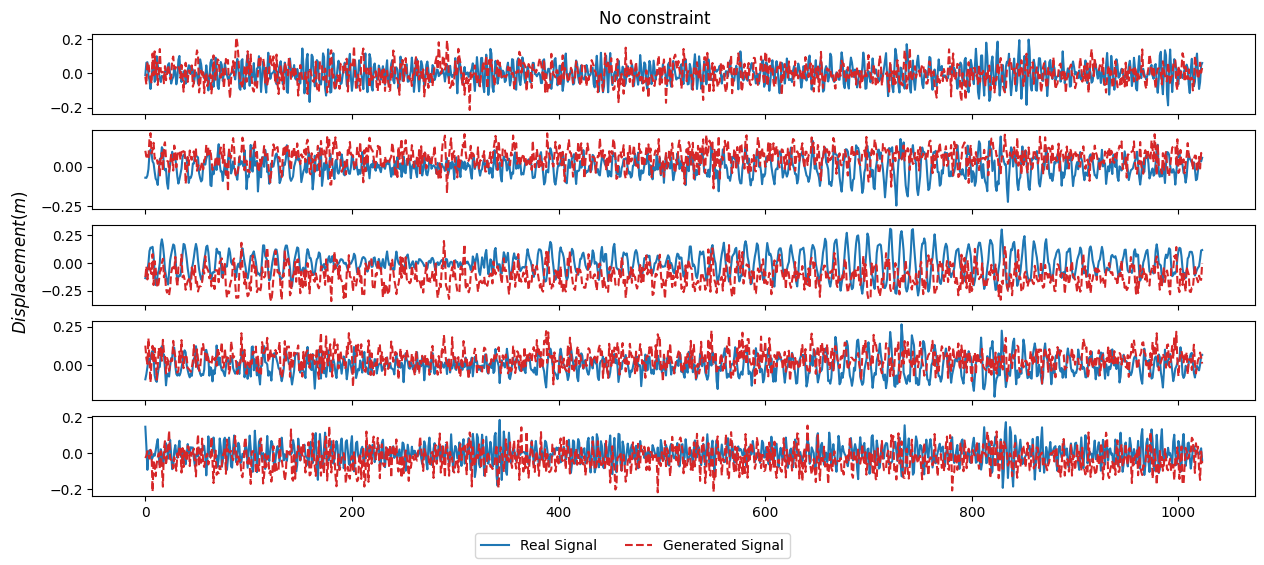

In [13]:
fig = visualize(scale_generated_signal_no_mean[0, :, :], scale_real_signal_no_mean[0, :, :])
fig.suptitle("No constraint", y=0.92)
plt.savefig("./pic/Generated Signal (no constraint).svg", bbox_inches = "tight")
plt.savefig("./pic/Generated Signal (no constraint).png", bbox_inches = "tight", dpi=500)

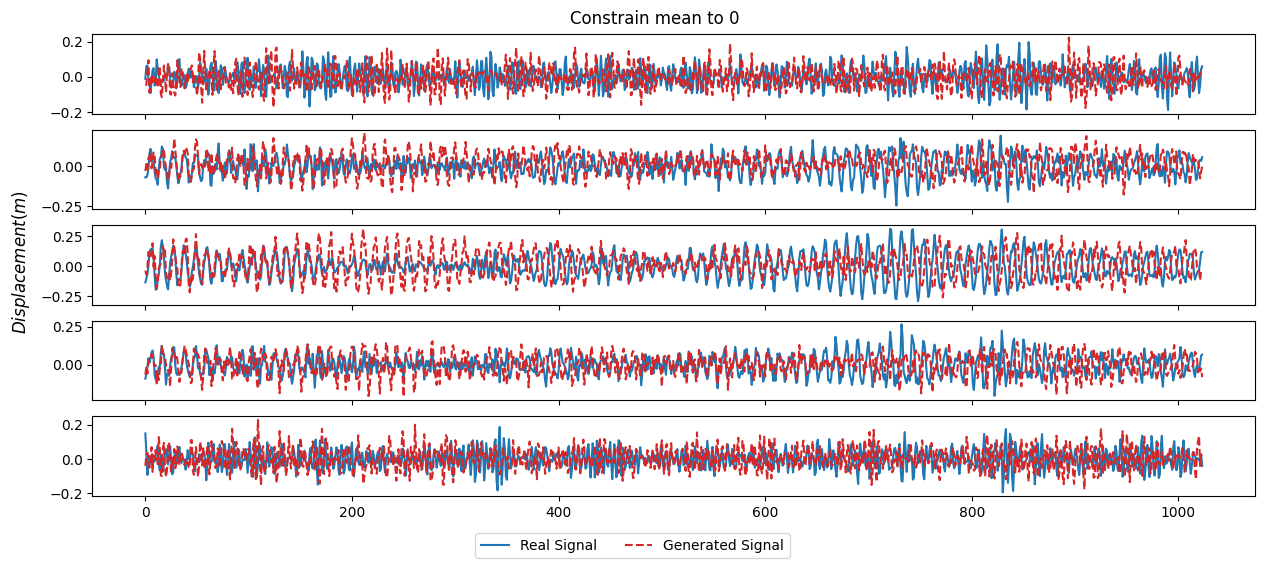

In [14]:
fig = visualize(scale_generated_signal_mean[0, :, :], scale_real_signal_mean[0, :, :])
fig.suptitle("Constrain mean to 0", y=0.92)
plt.savefig("./pic/Generated Signal (with constraint).svg", bbox_inches = "tight")
plt.savefig("./pic/Generated Signal (with constraint).png", bbox_inches = "tight", dpi=500)

In [15]:
import scipy
from scipy.fft import fft, fftfreq

In [16]:
N = 1024
T = 1.0 / 100
xf = fftfreq(N, T)[:N//2]

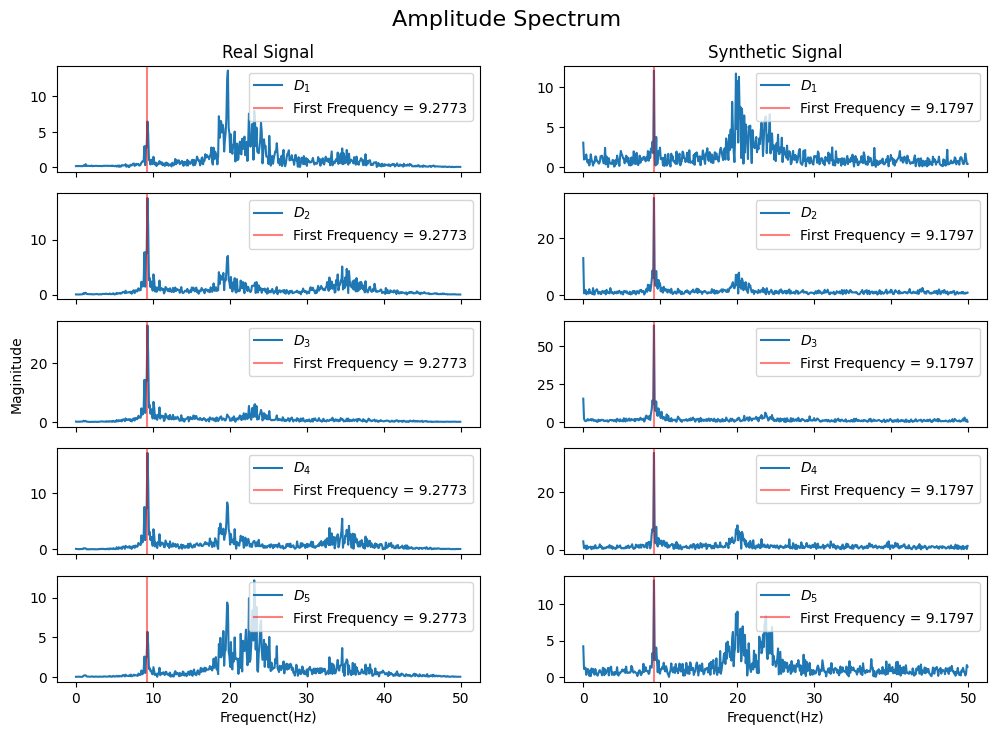

In [25]:
id = 502

fig, ax = plt.subplots(5, 2, figsize=(12,8), sharex=True)
for i in range(5):
    yt = scipy.fft.fft(scale_real_signal_mean[id][i, :N])
    first_mode = np.argmax(np.abs(yt[:N//10]))
    ax[i][0].plot(xf, np.abs(yt[:N//2]), label=r"$D_{%d}$" %(i+1))
    ax[i][0].axvline(x = xf[first_mode], color = 'r', alpha=0.5, label=f"First Frequency = {xf[first_mode]:.4f}")
    ax[i][0].legend(loc = 'upper right')

for i in range(5):
    yt = scipy.fft.fft(scale_generated_signal_mean[id][i, :N])
    first_mode = np.argmax(np.abs(yt[:N//10]))
    ax[i][1].plot(xf, np.abs(yt[:N//2]), label=r"$D_{%d}$" %(i+1))
    ax[i][1].axvline(x = xf[first_mode], color = 'r', alpha=0.5, label=f"First Frequency = {xf[first_mode]:.4f}")
    ax[i][1].legend(loc = 'upper right')

ax[0][0].set_title("Real Signal")
ax[0][1].set_title("Synthetic Signal")

ax[2][0].set_ylabel("Maginitude")
ax[4][0].set_xlabel("Frequenct(Hz)")
ax[4][1].set_xlabel("Frequenct(Hz)")

fig.suptitle("Amplitude Spectrum", fontsize=16, y=0.95)
plt.savefig("./pic/Amplitude Specturm.svg", bbox_inches='tight')
plt.savefig("./pic/Amplitude Specturm.png", bbox_inches='tight', dpi=500)

In [18]:
sample_num = 5000

In [19]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

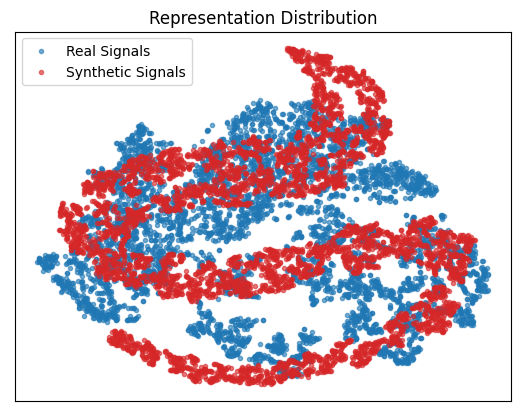

In [26]:
sample_real = real_representation_list[:sample_num,:, :].squeeze()
sample_synthetic = generative_representation_list_mean[:sample_num,:, : ].squeeze()
real_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=0).fit_transform(sample_real)
synthetic_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state=0).fit_transform(sample_synthetic)
fig = plt.figure()
plt.scatter(real_embedded[:, 0], real_embedded[:, 1], marker=".", c="tab:blue", alpha=0.6, label="Real Signals")
plt.scatter(synthetic_embedded[:, 0], synthetic_embedded[:, 1], marker=".", c="tab:red", alpha=0.6, label="Synthetic Signals")

plt.title("Representation Distribution")
plt.xticks([])
plt.yticks([])
plt.legend()
plt.savefig("./pic/TSNE.svg", bbox_inches="tight")
plt.savefig("./pic/TSNE.png", bbox_inches="tight", dpi=500)